## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Import modules, set options

In [149]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [150]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [151]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [152]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


#### Filter

In [153]:
#train_csv, _ = train_test_split(train_csv, test_size=0.9, random_state=42)

#### Train_CSV Params

In [154]:
train_csv.describe()

,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,6.915783e+04,1.335689e+01,5.883966e+00,1.589904e+01
std,3.661127e+04,3.267712e+00,4.993943e+00,3.477050e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01
25%,3.900200e+04,1.100000e+01,2.000000e+00,-2.549780e-01
50%,7.160900e+04,1.300000e+01,5.000000e+00,2.281130e+00
75%,1.008060e+05,1.600000e+01,8.000000e+00,7.390655e+00
max,1.338840e+05,2.800000e+01,2.800000e+01,2.048800e+02


In [155]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [156]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [157]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [158]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [159]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

### Functions

In [160]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [161]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [162]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [163]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [164]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))



def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [165]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [166]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [167]:
def build_couple_dataframeOld(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [168]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    output = output.drop(atoms_names, axis=1)
    return output

In [169]:
def map_atom_info(df, atom_idx):
    structures = structures_csv[['molecule_index', 'atom_index', 'atom']]
    structures = structures_csv
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_index', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_index',  'atom_index'])
    df = df.rename(columns={'atom': f'atom_{atom_idx}'});
    #df = df.drop('atom_index', axis=1)    
    return df

### Проверяем, что для каждого типа молекулы только  atom_1 принимает только одно значение

In [170]:
invest0 = map_atom_info(train_csv, 1)
invest0 = invest0[['type','atom_1']]
invest0.groupby(['type']).mean()

,atom_1
type,
1JHC,6
1JHN,7
2JHC,6
2JHH,1
2JHN,7
3JHC,6
3JHH,1
3JHN,7


## Check Regressions for a simple type

## New heading

In [171]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df


def build_atoms(base_from, structures_from, n_atoms):
    base = base_from
    structures = structures_from

    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in atoms:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)

    add_center(atoms)

    atoms = merge_all_atoms(atoms, structures)
        
    add_distance_to_center(atoms)

    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    atoms = atoms.drop(['atom_index'], axis=1)
    atoms = atoms.set_index(['x_c', 'y_c', 'z_c', 
        'molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()

    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    return atoms


In [172]:
def add_distance_to_center(df):
    df['d_c'] = ((
        ( df['x'] -  df['x_c'])**np.float32(2) +
        ( df['y'] -  df['y_c'])**np.float32(2) + 
        ( df['z'] -  df['z_c'])**np.float32(2)
    )**np.float32(0.5))
    

def cross_prod(v1, v2):
    outp0 = v1[1] * v2[2] - v1[2] * v2[1]
    outp1 = v1[2] * v2[0] - v1[0] * v2[2]
    outp2 = v1[0] * v2[1] - v1[1] * v2[0]
    outp = pd.concat([outp0, outp1,outp2], axis=1)
    return outp


def add_axis_x(df):
    n_x = df.x_0 - df.x_c
    n_y = df.y_0 - df.y_c
    n_z = df.z_0 - df.z_c
    axisFrame = pd.concat([n_x, n_y, n_z], axis=1)
    axisNorm = np.sqrt(np.square(axisFrame).sum(axis=1))
    df['ax_x'] = axisFrame[0] / axisNorm
    df['ax_y'] = axisFrame[1] / axisNorm
    df['ax_z'] = axisFrame[2] / axisNorm


def add_axis_y(df):
    r_vec = pd.concat([df.x_2 - df.x_c, 
                 df.y_2 - df.y_c,
                 df.z_2 - df.z_c], axis=1)
    axis_vec = pd.concat([df['ax_x'], 
                          df['ax_y'], 
                          df['ax_z']], axis=1)
    axis_vec.columns = [0, 1, 2]
    dist =  axis_vec[0] * r_vec[0] + axis_vec[1] * r_vec[1] + axis_vec[2] * r_vec[2]
    yDir = r_vec - axis_vec.multiply(dist, axis="index")
    yDirNorm = np.sqrt(np.square(yDir).sum(axis=1))
    df['ay_x'] = yDir[0] / yDirNorm
    df['ay_y'] = yDir[1] / yDirNorm
    df['ay_z'] = yDir[2] / yDirNorm    

def add_axis_z(df):    
    r_vec = pd.concat([df.x_2 - df.x_c, 
         df.y_2 - df.y_c,
         df.z_2 - df.z_c], axis=1)
    axis_x_vec = pd.concat([df['ax_x'], 
                      df['ax_y'], 
                      df['ax_z']], axis=1)
    axis_x_vec.columns = [0, 1, 2]
    axis_y_vec = pd.concat([df['ay_x'], 
                      df['ay_y'], 
                      df['ay_z']], axis=1)
    axis_y_vec.columns = [0, 1, 2]
    axis_z_vec = cross_prod(axis_x_vec, axis_y_vec)
    df['az_x'] = axis_z_vec[0] 
    df['az_y'] = axis_z_vec[1] 
    df['az_z'] = axis_z_vec[2] 


    
#add coordinates in frame ax,ay,az
def add_r_per_atom(df, suffix):
    x_loc = df[f'x_{suffix}'] - df.x_c
    y_loc = df[f'y_{suffix}'] - df.y_c
    z_loc = df[f'z_{suffix}'] - df.z_c
    r_x =  df['ax_x'] * x_loc + df['ax_y'] * y_loc + df['ax_z'] * z_loc
    r_y =  df['ay_x'] * x_loc + df['ay_y'] * y_loc + df['ay_z'] * z_loc
    r_z =  df['az_x'] * x_loc + df['az_y'] * y_loc + df['az_z'] * z_loc
    df[f'r_x_{suffix}'] = r_x
    df[f'r_y_{suffix}'] = r_y
    df[f'r_z_{suffix}'] = r_z
            
def add_r(df):    
    n_atoms = len([col for col in df if col.startswith('x_')]) - 1
    for i in range(1, n_atoms):
            add_r_per_atom(df, i)
            
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    
    atoms = build_atoms(base, structures, n_atoms)
    df = add_atoms(base, atoms)
    
    add_axis_x(df)
    add_axis_y(df)
    add_axis_z(df)
    add_r(df)

    df.sort_values('id', inplace=True)
    return df


In [173]:
%%time
molecule_index = 50893
some_csv = train_csv[train_csv.molecule_index == molecule_index]
#some_csv = train_csv #[:6000]
coupling_type = '1JHC'
n_atoms = 10
full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms)
full.head()

Wall time: 127 ms


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,ax_x,ax_y,ax_z,ay_x,ay_y,ay_z,az_x,az_y,az_z,r_x_1,r_y_1,r_z_1,r_x_2,r_y_2,r_z_2,r_x_3,r_y_3,r_z_3,r_x_4,r_y_4,r_z_4,r_x_5,r_y_5,r_z_5,r_x_6,r_y_6,r_z_6,r_x_7,r_y_7,r_z_7,r_x_8,r_y_8,r_z_8,r_x_9,r_y_9,r_z_9
0,1567330,50893,10,1,140.645004,0.634779,-0.462826,-0.739286,-0.133810,0.038041,-0.150691,0.250485,-0.212392,-0.444989,7,8,1,6,8,7,1,1,-0.256479,-1.090539,0.509465,-0.941471,-0.039216,-1.970939,-2.699512,-1.220216,1.252988,-0.831051,1.787187,-2.158229,-2.629475,-2.850358,-2.328591,-4.609975,0.143031,0.318055,-0.264027,0.003972,-0.643397,0.563172,1.023855,-0.179480,0.705145,-0.459522,-0.540008,0.459768,0.876096,-0.145150,0.539799,-0.145927,0.829049,-0.544986,8.690331e-09,-1.344103e-08,-1.348394,0.965377,1.665335e-16,-1.073379,-1.269321,-0.001004,-0.833953,1.844628,-0.001969,-0.188789,-2.317930,0.012743,1.013565,-2.221993,0.031846,-0.898638,-3.478787,0.021642,-1.900923,-3.423511,-0.065852,0.840353,-4.567426,0.067962
1,1567340,50893,12,6,103.942001,-1.220216,-4.609975,-0.179480,-2.127082,-4.268234,0.327516,-1.673649,-4.439105,0.074018,1,7,6,6,1,8,7,8,-2.210247,-1.970939,-3.300507,-0.941471,-2.699512,-0.039216,-4.236725,-1.090539,-4.815596,-2.850358,-4.583531,-2.158229,-2.328591,-2.629475,-4.827504,-0.831051,1.273320,0.563172,-0.501114,0.003972,1.023855,-0.643397,-1.131620,0.318055,0.829152,-0.312455,-0.463550,0.187651,-0.625536,0.757293,-0.526587,-0.714896,-0.460032,-0.546864,-3.206483e-07,-2.781151e-07,-0.883221,1.043038,-1.110223e-16,-0.969658,-0.679172,-1.204267,-1.037184,-0.650480,1.224511,-0.073115,-1.342422,-1.983922,-1.950334,-0.793401,-1.405548,1.122323,-1.368580,-1.824335,-1.444950,-1.151026,2.181979,-0.756991,-1.962738,-2.998708
2,1567346,50893,13,6,92.774101,-2.210247,-4.815596,1.273320,-2.127082,-4.268234,0.327516,-2.168664,-4.541915,0.800418,1,7,6,1,6,7,8,8,-1.220216,-1.970939,-3.300507,-2.699512,-0.941471,-4.236725,-0.039216,-1.090539,-4.609975,-2.850358,-4.583531,-2.328591,-2.158229,-4.827504,-2.629475,-0.831051,-0.179480,0.563172,-0.501114,1.023855,0.003972,-1.131620,-0.643397,0.318055,-0.075885,-0.499449,0.863014,0.846727,-0.489362,-0.208753,0.526587,0.714896,0.460032,-0.547966,-2.080969e-07,-1.118382e-07,-0.883646,1.040940,-1.110223e-16,-1.064597,-0.610838,1.204266,-1.016565,-0.666298,-1.224512,-0.872329,-1.579242,1.405547,-1.970999,0.038874,1.983921,-1.367803,-1.208008,-2.181981,-2.362792,1.168588,1.824335,-2.351486,-0.802381,2.998706


## Break!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [174]:
#aaaa

## New heading

In [175]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHC', n_atoms=10)
full.head()

KeyboardInterrupt: 

In [176]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(1, n_atoms):
        labels.append(f'r_x_{i}')
    for i in range(2, n_atoms):
        labels.append(f'r_y_{i}')
    for i in range(3, n_atoms):
        labels.append(f'r_z_{i}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    #atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    #output = output.drop(atoms_names, axis=1)
    return output

In [177]:
df = take_n_atoms(full, 10)
df.head()


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,r_x_1,r_x_2,r_x_3,r_x_4,r_x_5,r_x_6,r_x_7,r_x_8,r_x_9,r_y_2,r_y_3,r_y_4,r_y_5,r_y_6,r_y_7,r_y_8,r_y_9,r_z_3,r_z_4,r_z_5,r_z_6,r_z_7,r_z_8,r_z_9,scalar_coupling_constant
0,7,8,1,6,8,7,1,1,-0.544986,-1.348394,-1.073379,-0.833953,-0.188789,1.013565,-0.898638,-1.900923,0.840353,0.965377,-1.269321,1.844628,-2.317930,-2.221993,-3.478787,-3.423511,-4.567426,-0.001004,-0.001969,0.012743,0.031846,0.021642,-0.065852,0.067962,140.645004
1,1,7,6,6,1,8,7,8,-0.546864,-0.883221,-0.969658,-1.037184,-0.073115,-1.950334,1.122323,-1.444950,-0.756991,1.043038,-0.679172,-0.650480,-1.342422,-0.793401,-1.368580,-1.151026,-1.962738,-1.204267,1.224511,-1.983922,-1.405548,-1.824335,2.181979,-2.998708,103.942001
2,1,7,6,1,6,7,8,8,-0.547966,-0.883646,-1.064597,-1.016565,-0.872329,-1.970999,-1.367803,-2.362792,-2.351486,1.040940,-0.610838,-0.666298,-1.579242,0.038874,-1.208008,1.168588,-0.802381,1.204266,-1.224512,1.405547,1.983921,-2.181981,1.824335,2.998706,92.774101


For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [178]:
df = take_n_atoms(full, 9)

#inverse of distances
#filter_col = [col for col in df if col.startswith('d_')]
#df[filter_col] = 1 / (df[filter_col])
#df.head()

# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'r_x_1', 'r_x_2', 'r_x_3', 'r_x_4', 'r_x_5', 'r_x_6', 'r_x_7', 'r_x_8',
       'r_y_2', 'r_y_3', 'r_y_4', 'r_y_5', 'r_y_6', 'r_y_7', 'r_y_8', 'r_z_3',
       'r_z_4', 'r_z_5', 'r_z_6', 'r_z_7', 'r_z_8',
       'scalar_coupling_constant'],
      dtype='object')

In [179]:
# df.hist(bins=10, figsize = [20,20] )

In [180]:
#df.plot.scatter(x='dist_along_1', y = 'scalar_coupling_constant') 

In [181]:
#X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
#y_data = df['scalar_coupling_constant'].values.astype('float32')
X_data = df.drop(['scalar_coupling_constant'], axis=1)
y_data = df['scalar_coupling_constant']


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2, 28), (1, 28), (2,), (1,))

## CatBoost

In [182]:
from catboost import CatBoostRegressor

In [183]:
CAT_PARAMS = {
          'learning_rate': 0.5,
           'max_depth': 5,    
           'n_estimators': 50
         }
#categorical features

categorical_features = [col for col in X_train if col.startswith('atom_')]
model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
          cat_features = categorical_features,
          use_best_model=True,
          verbose=True)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

0:	learn: 98.2955513	test: 140.5825043	best: 140.5825043 (0)	total: 3.04ms	remaining: 149ms
1:	learn: 98.2330513	test: 140.5200043	best: 140.5200043 (1)	total: 5.91ms	remaining: 142ms
2:	learn: 98.1705513	test: 140.4575043	best: 140.4575043 (2)	total: 8.36ms	remaining: 131ms
3:	learn: 98.1080513	test: 140.3950043	best: 140.3950043 (3)	total: 11ms	remaining: 126ms
4:	learn: 98.0455513	test: 140.3325043	best: 140.3325043 (4)	total: 13.7ms	remaining: 123ms
5:	learn: 97.9830513	test: 140.2700043	best: 140.2700043 (5)	total: 16.1ms	remaining: 118ms
6:	learn: 97.9205513	test: 140.2075043	best: 140.2075043 (6)	total: 18.7ms	remaining: 115ms
7:	learn: 97.8580513	test: 140.1450043	best: 140.1450043 (7)	total: 21.1ms	remaining: 111ms
8:	learn: 97.7955513	test: 140.0825043	best: 140.0825043 (8)	total: 23.6ms	remaining: 107ms
9:	learn: 97.7330513	test: 140.0200043	best: 140.0200043 (9)	total: 26.4ms	remaining: 106ms
10:	learn: 97.6705513	test: 139.9575043	best: 139.9575043 (10)	total: 28.9ms	remai

4.923769392142518

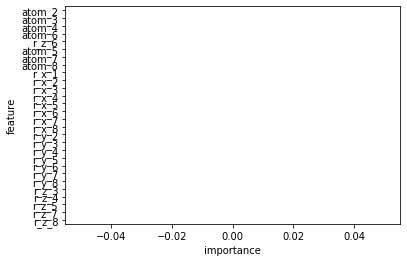

In [184]:
cols = list(X_train.columns)
#cols.remove('scalar_coupling_constant')
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

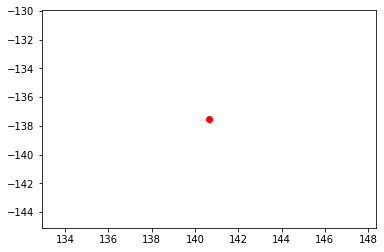

In [185]:
plt.plot(y_val, y_pred - y_val, 'ro')

## LGBMRegressor

In [186]:
#aaa

In [187]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
if False:
    LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
    }
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 25,
    'min_child_samples': 60,
    'max_depth': 4,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [188]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=100000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=500)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 500 rounds.
[100]	training's l1: 98.3581	valid_1's l1: 56.0711
[200]	training's l1: 98.3581	valid_1's l1: 56.0711
[300]	training's l1: 98.3581	valid_1's l1: 56.0711
[400]	training's l1: 98.3581	valid_1's l1: 56.0711
[500]	training's l1: 98.3581	valid_1's l1: 56.0711
Early stopping, best iteration is:
[1]	training's l1: 98.3581	valid_1's l1: 56.0711


3.7444785981062103

Not a bad score for such a simple set of features.

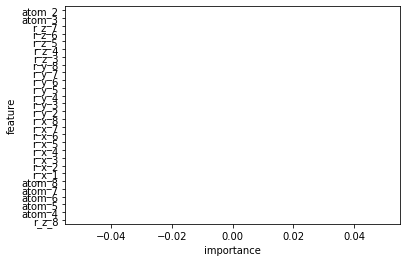

In [189]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

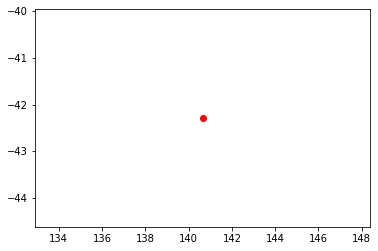

In [190]:
plt.plot(y_val, y_pred- y_val, 'ro')

It's funny, but looks like atom types aren't used a lot in the final decision. Quite a contrary to what a man would do.

## Submission Model


In [191]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1)
        y_data = df['scalar_coupling_constant']
    else:
        X_data = df
        y_data = None
    
    return X_data, y_data

In [192]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    model_type =  'lgb' #lgb  cat
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    columns = X_data.columns 
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        #X_train, X_val = X_data[train_index], X_data[val_index]
        #y_train, y_val = y_data[train_index], y_data[val_index]
        X_train, X_val = X_data[columns].iloc[train_index], X_data[columns].iloc[val_index]
        y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

        model = ""
        if model_type == 'lgb':
            model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
            #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
            model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
                verbose=100, early_stopping_rounds=200)
        
        if model_type == 'cat': 
            categorical_features = [col for col in X_train if col.startswith('atom_')]
            model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
            X_trainGlob = X_train
            model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
                      cat_features = categorical_features,
                      use_best_model=True,
                      verbose=False)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [193]:
categorical_features

['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8']

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [194]:
if False: 
    model_params = {
        '1JHC': 10,
        '1JHN': 7,    
        '2JHH': 9,
        '2JHN': 9,
        '2JHC': 9,
        '3JHH': 9,
        '3JHC': 10,
        '3JHN': 10
    }
model_params = {
    '1JHC': 7,
    '1JHN': 7,    
    '2JHH': 7,
    '2JHN': 7,
    '2JHC': 7,
    '3JHH': 7,
    '3JHC': 7,
    '3JHN': 7
}


Checking cross-validation scores for each type:

In [195]:
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHC ***


KeyboardInterrupt: 

In [ ]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

And cv mean score:

In [ ]:
np.mean(list(cv_scores.values()))

Sanity check for all cells to be filled with predictions:

In [ ]:
submission[submission['scalar_coupling_constant'] == 0].shape

In [ ]:
submission.head(10)

In [ ]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

## a!!!